# Setting up the empirical-based household load profiles

Goal: Setting up 500 profiles of households, based on empirical or semi-empirical data for the year 2019.

## Components

**Heat pumps**: Water-to-water heat pump load profiles, based on Schlemminger et al. (2022)'s real-world profiles. Enriched to 500 profiles through the approach of Semmelmann et al. (2023).

**Household data**: Finding the corresponding real-world household load profiles from Schlemminger et al. (2022).

**Electric vehicles**: Real-world Norwegian electric vehicle charging profiles from Sørensen et al. (2021). Taking unique user charging sessions. To come up with 500 profiles, load profiles are shifted between [-4,4] weeks. Only shifting full weeks, to ensure daily integrity. 

**BESS sizes**: Power ratings and capacities of household battery energy storage systems (BESS) are taken from Semmelmann et al. (2024, unpublished), based on a realistic sample of German residential households. 

**PV load data**: From renewables.ninja for Hamelin in 2019, the city from which the heat pump and household load profiles are obtained, based on Pfenninger and Staffell (2016). PV sized equal to BESS capacit / h, corresponding to average German households, depicted in Truong et al. (2016). 

## Output

The following output files are generated:

- HP profiles
- HH profiles
- PV profile normed on 1kW rated power
- EV profiles
- Household config: includes for 500 households: A) column of HP and B) HH profile C) BESS capacity (drawn based on distribution) D) BESS rated power (derived from capacity) E) PV power (derived from capacity)


## Sources

- Semmelmann, L., Jaquart, P., & Weinhardt, C. (2023). Generating synthetic load profiles of residential heat pumps: a k-means clustering approach. Energy Informatics, 6(Suppl 1), 37.
- Schlemminger, M., Ohrdes, T., Schneider, E., & Knoop, M. (2022). Dataset on electrical single-family house and heat pump load profiles in Germany. Scientific data, 9(1), 56.
- Sørensen, Å. L., Lindberg, K. B., Sartori, I., & Andresen, I. (2021). Residential electric vehicle charging datasets from apartment buildings. Data in Brief, 36, 107105.
- Pfenninger, S., & Staffell, I. (2016). Long-term patterns of European PV output using 30 years of validated hourly reanalysis and satellite data. Energy, 114, 1251-1265.
- Truong, C. N., Naumann, M., Karl, R. C., Müller, M., Jossen, A., & Hesse, H. C. (2016). Economics of residential photovoltaic battery systems in Germany: The case of Tesla’s Powerwall. Batteries, 2(2), 14.


In [3]:
# IMPORTS
import datetime
import random
import pandas as pd
import numpy as np

In [2]:
# GENERAL SETUP
amount_households = 500
households = [] # empty list of dictionaries for household information

In [3]:
print(pd.__version__)
print(np.__version__)

1.5.2
1.21.4


In [4]:
# HEAT PUMP: Iterating over given synthetic household profiles for Hamelin in 2019

df_heat_pumps = pd.read_pickle("./input/2019 Hamelin 500 HP.pkl")
for i in range(amount_households):
    households.append({"heat_pump_profile":df_heat_pumps.columns[i],"hp_yearly_consumption":df_heat_pumps[df_heat_pumps.columns[i]].sum()/1000,"household_profile":df_heat_pumps.columns[i]})

In [5]:
# HOUSEHOLD: For every household, 
#look up when the corresponding heat pump load was observed and take the household counterpart

df_households_source = pd.read_pickle("./input/1920 Final Data w. Additional Features HH Hourly Agg.pkl")
df_heat_pumps_source = pd.read_pickle("./input/1920 Final Data w. Additional Features HP Hourly Agg.pkl")
df_heat_pumps_source_24th_rows = df_heat_pumps_source.iloc[::24, :]
df_heat_pumps_source_24th_rows

heat_pump_loads_target = df_heat_pumps
heat_pump_loads_target_24th_rows = heat_pump_loads_target.iloc[::24, :]
heat_pump_loads_target_24th_rows

df_households_target = df_heat_pumps.copy()

for total_col in df_households_target.columns:
    print(total_col)
    heat_pump_loads_target_24th_rows_spec = heat_pump_loads_target_24th_rows[total_col]
    col = "SFH"+total_col.split("SFH")[1]
    for i in range(0, len(heat_pump_loads_target_24th_rows_spec)):
        first_hp_load = heat_pump_loads_target_24th_rows_spec.iloc[i]
        for idx,val in enumerate(df_heat_pumps_source_24th_rows[col].values):
            if first_hp_load == val:
                target_values = df_households_source[col].iloc[(idx*24):(idx+1)*24]
                df_households_target.loc[i*24:(i+1)*24,total_col] = target_values.values

df_households_target.to_pickle("./input/2019 Hamelin 500 HH.pkl")

0_SFH19_P_TOT
1_SFH18_P_TOT
2_SFH4_P_TOT


C:\Users\kkaiser\AppData\Local\Temp\ipykernel_10036\1009965143.py:24: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df_households_target.loc[i*24:(i+1)*24,total_col] = target_values.values


3_SFH30_P_TOT
4_SFH3_P_TOT
5_SFH3_P_TOT
6_SFH12_P_TOT
7_SFH5_P_TOT
8_SFH18_P_TOT
9_SFH34_P_TOT
10_SFH30_P_TOT
11_SFH18_P_TOT
12_SFH7_P_TOT
13_SFH22_P_TOT
14_SFH4_P_TOT
15_SFH19_P_TOT
16_SFH30_P_TOT
17_SFH30_P_TOT
18_SFH38_P_TOT
19_SFH34_P_TOT
20_SFH16_P_TOT
21_SFH16_P_TOT
22_SFH29_P_TOT
23_SFH19_P_TOT
24_SFH19_P_TOT
25_SFH12_P_TOT
26_SFH32_P_TOT
27_SFH29_P_TOT
28_SFH16_P_TOT
29_SFH22_P_TOT
30_SFH32_P_TOT
31_SFH4_P_TOT
32_SFH14_P_TOT
33_SFH12_P_TOT
34_SFH21_P_TOT
35_SFH21_P_TOT
36_SFH21_P_TOT
37_SFH22_P_TOT
38_SFH29_P_TOT
39_SFH16_P_TOT
40_SFH18_P_TOT
41_SFH14_P_TOT
42_SFH28_P_TOT
43_SFH19_P_TOT
44_SFH5_P_TOT
45_SFH12_P_TOT
46_SFH7_P_TOT
47_SFH5_P_TOT
48_SFH38_P_TOT
49_SFH3_P_TOT
50_SFH18_P_TOT
51_SFH16_P_TOT
52_SFH30_P_TOT
53_SFH12_P_TOT
54_SFH9_P_TOT
55_SFH38_P_TOT
56_SFH39_P_TOT
57_SFH36_P_TOT
58_SFH32_P_TOT
59_SFH28_P_TOT
60_SFH27_P_TOT
61_SFH7_P_TOT
62_SFH20_P_TOT
63_SFH38_P_TOT
64_SFH39_P_TOT
65_SFH5_P_TOT
66_SFH20_P_TOT
67_SFH32_P_TOT
68_SFH30_P_TOT
69_SFH9_P_TOT
70_SFH29_P_TOT
7

In [6]:
# calculate hh consumption and aggregate consumption:
for household in households:
    yearly_sum_hh = df_households_target[household["household_profile"]].sum()/1000
    aggregate_consumption = household["hp_yearly_consumption"]+yearly_sum_hh
    household = household.update({"hh_yearly_consumption":yearly_sum_hh,"total_yearly_consumption":aggregate_consumption})

In [7]:
# ELECTRIC VEHICLES: Matching EV profiles to households and saving the shifted profiles
# read EV data with multi-column index
ev_df = pd.read_csv("./input/Hourly_EV_Charging.csv", sep=";", header=[0,1], index_col=0)
ev_df.index = pd.to_datetime(ev_df.index)
print("Number of rows in ev_df: ", len(ev_df))

# determine unique users
ev_users = ev_df.columns.get_level_values(0).unique()
print("EV user IDs: ", list(ev_users))

Number of rows in ev_df:  8760
EV user IDs:  ['AdO1-1', 'AdO1-2', 'AdO1-3', 'AdO3-2', 'AdO3-3', 'AdO3-4', 'AsO2-1', 'Bl2-1', 'Bl2-2', 'Bl2-3', 'Bl2-4', 'Bl2-5', 'Bl2-6']


In [8]:
# match an EV profile to each household and determine by how many weeks the EV profile is shifted
for household in households:
    shift_weeks = random.randint(-4, 4)
    household = household.update({"ev_col": random.choice(ev_users), "ev_shift_weeks": shift_weeks})

In [9]:
# create a new dataframe with the shifted EV profiles
assert (ev_df.index == df_heat_pumps.index).all(), "Indices of EV and heat pump dataframes do not match"
level_0 = df_heat_pumps.columns
level_1 = ev_df.columns.get_level_values(1).unique()
df_ev_target = pd.DataFrame(index=ev_df.index, columns=pd.MultiIndex.from_product([level_0, level_1], names=["household", "ev_info"]))

# iterate over all households
for idx, col in enumerate(level_0):
    ev_col = households[idx]["ev_col"]
    time_steps_shift = households[idx]["ev_shift_weeks"] * 7 * 24  # integer number of time steps to shift the EV profile
    idx_shift = ev_df.index[-time_steps_shift]  # corresponding time stamp at which the EV profile is split

    # EV profile of the matched user
    ev_df_u = ev_df.loc[:, ev_col].copy()  # copy the EV profile to avoid modifying the original dataframe

    # check whether the split due to shifting is in the middle of a charging session;
    # this charging session will be neglected;
    # reasoning: if we split it, there may be a high charging peak in time step 0 in the uncontrolled case (all EVs for which charging session has been split are charged at the same time)
    if ev_df_u.loc[idx_shift, "Wh"] > 0 and ev_df_u.loc[idx_shift, "start"] == 0:
        # find the start and end of the charging session
        idx_start = ev_df_u.loc[:idx_shift][ev_df_u.loc[:idx_shift, "start"] == 1].index[-1]
        idx_end = idx_start + datetime.timedelta(hours=ev_df_u.loc[idx_start, "hours_until_end"])
        # set the charging session to zero
        ev_df_u.loc[idx_start:idx_end] = 0  # idx_end is included

    shifted_ev_df = pd.concat([ev_df_u[idx_shift:], ev_df_u[:idx_shift - datetime.timedelta(hours=1)]]).reset_index(drop=True)
    df_ev_target[col] = shifted_ev_df.values

In [17]:
# save the shifted EV profiles
df_ev_target = df_ev_target.astype(np.float32) # reduce memory usage
df_ev_target.to_pickle("./input/2019 Hamelin 500 EV.pkl")

In [11]:
config = pd.DataFrame(households)
config

,heat_pump_profile,hp_yearly_consumption,household_profile,hh_yearly_consumption,total_yearly_consumption,ev_col,ev_shift_weeks
0,0_SFH19_P_TOT,2054.950933,0_SFH19_P_TOT,3418.300373,5473.251306,Bl2-6,-3
1,1_SFH18_P_TOT,2017.207650,1_SFH18_P_TOT,2798.392921,4815.600571,AsO2-1,4
2,2_SFH4_P_TOT,4846.940840,2_SFH4_P_TOT,3171.448391,8018.389231,Bl2-4,0
3,3_SFH30_P_TOT,1594.778375,3_SFH30_P_TOT,2114.571238,3709.349613,Bl2-5,0
4,4_SFH3_P_TOT,2418.016188,4_SFH3_P_TOT,2114.364762,4532.380950,Bl2-2,-1
...,...,...,...,...,...,...,...
495,495_SFH19_P_TOT,2080.026561,495_SFH19_P_TOT,3414.704362,5494.730922,AdO1-2,-4
496,496_SFH9_P_TOT,7179.126628,496_SFH9_P_TOT,4855.557803,12034.684430,Bl2-5,2
497,497_SFH4_P_TOT,4126.008064,497_SFH4_P_TOT,3172.634804,7298.642868,AdO3-4,-4
498,498_SFH20_P_TOT,13223.620291,498_SFH20_P_TOT,3292.330698,16515.950989,Bl2-1,-2


In [12]:
# BESS CAPACITY AND PV POWER: Draw from distribution BESS capacity, PV sized at BESS Capacity / 1h

capacities = [2.5, 5, 7.5, 10] # in kWh
probabilities = [6.7, 37.2, 31.5, 24.6] # in percent


def draw_bess_capacity(capacities, probabilities):
    total = sum(probabilities)
    normalized_probabilities = [p / total for p in probabilities]

    return random.choices(capacities, weights=normalized_probabilities, k=1)[0]

drawn_capacities = np.full(amount_households,0) # create an array of drawn capacities

for i in range(amount_households):
    capacity = draw_bess_capacity(capacities, probabilities)
    drawn_capacities[i] = capacity

drawn_capacities = np.sort(drawn_capacities)[::-1] # sort randomly drawn BESS capacities in an ascending order

In [13]:
# To realistically match pv and bess sizes to households, we sort the households by their total hh + hp consumption and then match pv sizes
config.sort_values("total_yearly_consumption",inplace=True,ascending=False)

average_c_rate = 0.41

config["bess_capacity"] = drawn_capacities
config["bess_power"] = config["bess_capacity"]*average_c_rate
config["pv_power"] = drawn_capacities

config

,heat_pump_profile,hp_yearly_consumption,household_profile,hh_yearly_consumption,total_yearly_consumption,ev_col,ev_shift_weeks,bess_capacity,bess_power,pv_power
158,158_SFH20_P_TOT,14099.950754,158_SFH20_P_TOT,3376.322629,17476.273383,AsO2-1,-4,10,4.10,10
262,262_SFH20_P_TOT,14084.830564,262_SFH20_P_TOT,3243.543113,17328.373677,AdO3-4,2,10,4.10,10
458,458_SFH20_P_TOT,13730.292642,458_SFH20_P_TOT,3328.310450,17058.603092,AsO2-1,3,10,4.10,10
348,348_SFH20_P_TOT,13556.119406,348_SFH20_P_TOT,3442.264178,16998.383583,Bl2-2,-4,10,4.10,10
356,356_SFH20_P_TOT,13648.211947,356_SFH20_P_TOT,3341.707210,16989.919156,Bl2-5,-2,10,4.10,10
...,...,...,...,...,...,...,...,...,...,...
361,361_SFH27_P_TOT,2381.655387,361_SFH27_P_TOT,1142.975176,3524.630563,AdO3-2,3,2,0.82,2
199,199_SFH27_P_TOT,2382.083910,199_SFH27_P_TOT,1133.798980,3515.882890,AdO1-2,3,2,0.82,2
234,234_SFH27_P_TOT,2277.750933,234_SFH27_P_TOT,1137.819234,3415.570166,AdO1-2,-4,2,0.82,2
193,193_SFH27_P_TOT,2287.072501,193_SFH27_P_TOT,1122.909575,3409.982076,Bl2-3,-1,2,0.82,2


In [14]:
# watch final result

config.to_pickle("./input/2019 Hamelin Household Configuration.pkl")

In [15]:
# find the days with the highest HP load 
df_heat_pumps.index = pd.to_datetime(df_heat_pumps.index)
df_heat_pumps.resample("D").sum().sum(axis=1).idxmax()

Timestamp('2019-12-01 00:00:00+0000', tz='UTC', freq='D')

In [16]:
# find the days with the highest PV load 
df_pv = pd.read_csv("./input/ninja_pv_52.1040_9.3562_uncorrected.csv",skiprows=3)
df_pv.set_index("local_time",inplace=True)
df_pv.index = pd.to_datetime(df_pv.index)
df_pv.resample("D").sum().idxmax()

C:\Users\kkaiser\AppData\Local\Temp\ipykernel_10036\2593471969.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_pv.resample("D").sum().idxmax()


electricity   2019-05-13
dtype: datetime64[ns]

In [12]:
### Here, we visualize the aggregated data over one year

df_ev = pd.read_pickle("./input/2019 Hamelin 500 EV.pkl")
df_hh = pd.read_pickle("./input/2019 Hamelin 500 HH.pkl")
df_hp = pd.read_pickle("./input/2019 Hamelin 500 HP.pkl")

In [26]:
# transforming multi level ev data
wh_columns = [col for col in df_ev.columns if 'Wh' in col[1]]  
wh_data = df_ev[wh_columns]
wh_data_sum = wh_data.sum(axis=1)

Text(0.5, 0, 'Time')

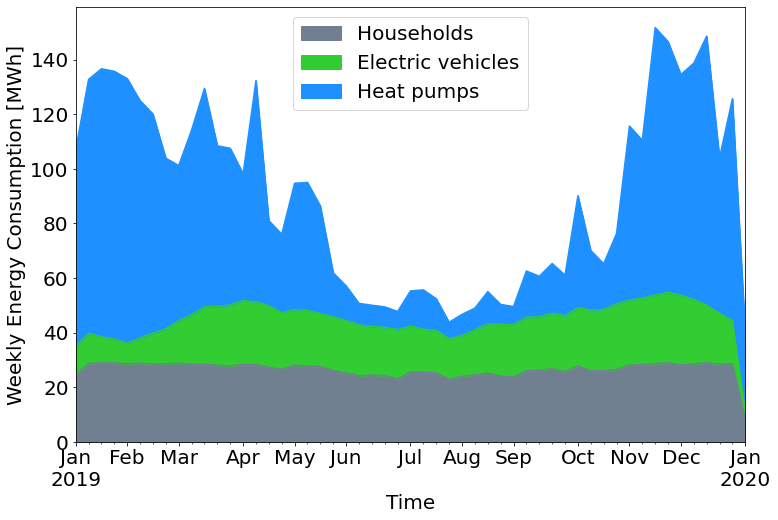

In [54]:
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 20})

consumption_df = pd.DataFrame()
consumption_df.index = pd.to_datetime(df_hh.index)
consumption_df["Households"] = df_hh.sum(axis=1).values
consumption_df["Electric vehicles"] = wh_data_sum
consumption_df["Heat pumps"]= df_hp.sum(axis=1).values
consumption_df = consumption_df.applymap(lambda x: x/1000000)
ax = consumption_df.resample("W").sum().plot.area(color=["slategrey","limegreen","dodgerblue"],figsize=(12,8))
ax.set_ylabel("Weekly Energy Consumption [MWh]")
ax.set_xlabel("Time")
